In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from scipy import stats
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier,
    VotingClassifier, RandomForestRegressor, ExtraTreesClassifier,
    StackingClassifier
)
from sklearn.linear_model import (
    LogisticRegression, SGDClassifier
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    precision_score, recall_score, f1_score,
    log_loss
)
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
)
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, StandardScaler
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics, linear_model, neighbors, ensemble, tree
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.pipeline import make_pipeline

from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE

import pickle

os.environ['LOKY_MAX_CPU_COUNT'] = '4'

import xgboost as xgb
from xgboost import XGBClassifier



In [2]:
# Read the CSV file with specified data types
df = pd.read_csv('final_dataset.csv', low_memory=False)

In [3]:
random_state=42

In [4]:
# Split the data into features (X) and the binary target variable (y)
X = df.drop(['action_taken'], axis=1)
y = df['action_taken']

In [5]:
df['co_applicant_ethnicity_1'].value_counts()

co_applicant_ethnicity_1
1.0    44071
0.0     5617
Name: count, dtype: int64

In [6]:
y.value_counts()

action_taken
0.0    27976
1.0    21712
Name: count, dtype: int64

In [7]:
# Define the minority classes for each column
minority_classes = {
    'applicant_sex': [0.2, 1.0, 0.4],
    'co_applicant_sex': [0.0, 1.0],
    'applicant_race_1': [0.0],
    'co_applicant_race_1': [0.0],
    'applicant_ethnicity_1': [0.0],
    'co_applicant_ethnicity_1': [0.0],
}

# Create a dictionary to store resampled datasets for each column
resampled_datasets = {}

# Iterate through the columns and apply SMOTE to each
for column, minority_class in minority_classes.items():
    
        # Select the specific column
        selected_column = df[column].values.reshape(-1, 1)

        # Define y_min based on the minority class for this column
        y_min = (df[column] == minority_class[0]).astype(int)

        # Apply SMOTE to the selected column
        smote = SMOTE(sampling_strategy='auto', random_state=42)
        X_resampled, y_resampled = smote.fit_resample(selected_column, y_min)

        # Store the resampled data in the dictionary
        resampled_datasets[column] = (X_resampled, y_resampled)



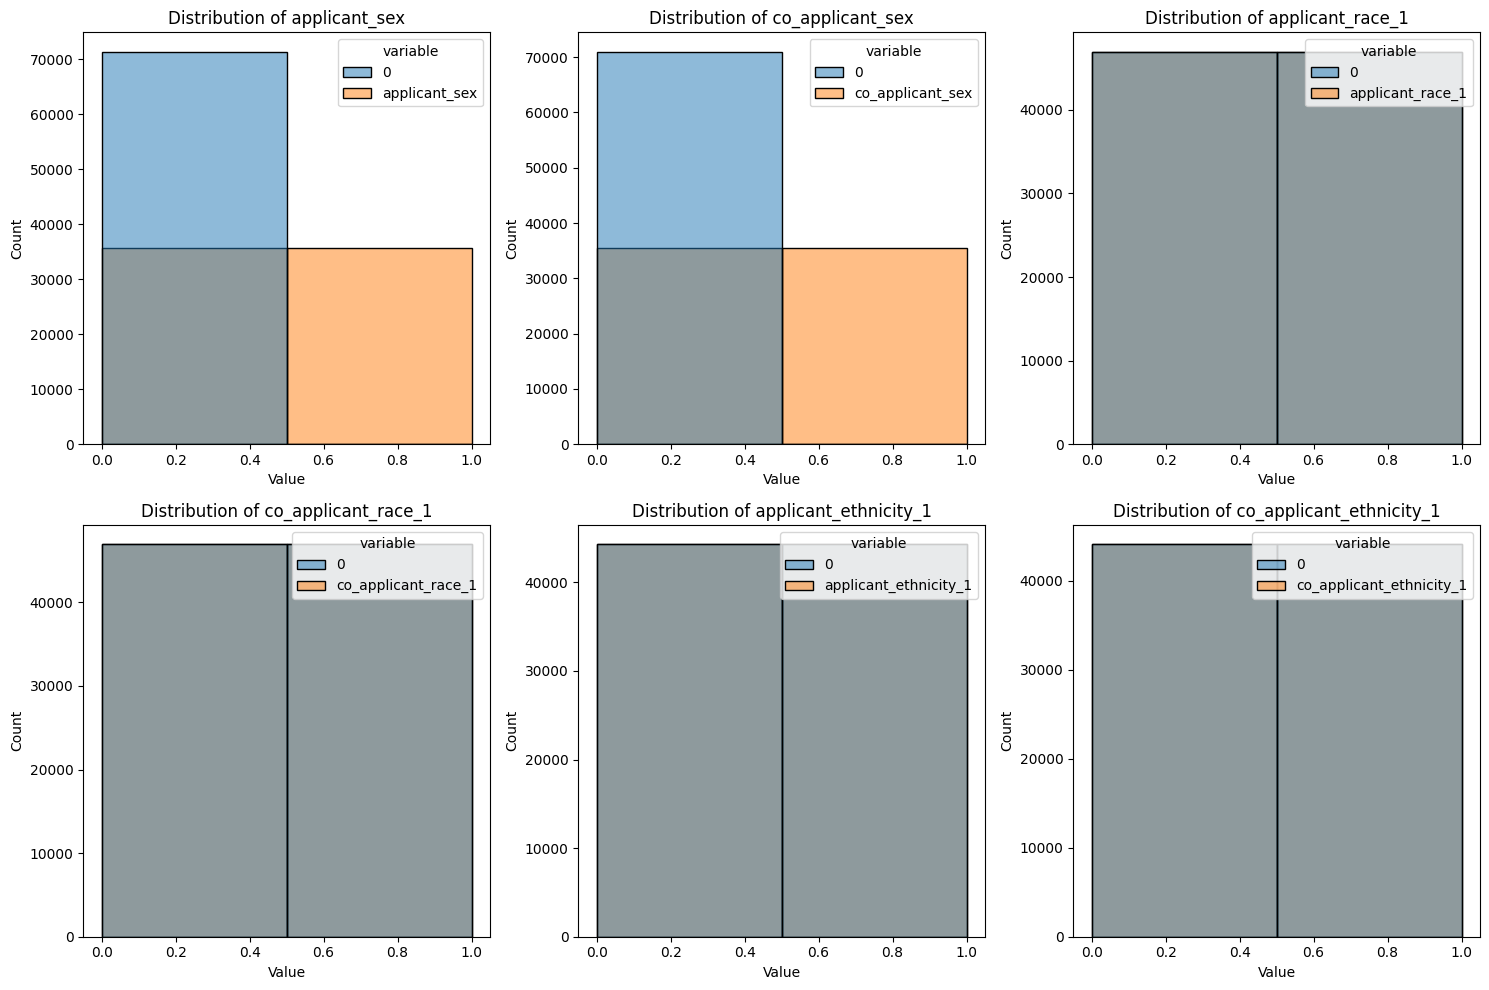

In [8]:
# Create a grid of histograms with 3 plots on every row
columns_to_plot = list(resampled_datasets.keys())

num_plots = len(columns_to_plot)
num_rows = (num_plots // 3) + (num_plots % 3)
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
axes = axes.ravel()

for i, column in enumerate(columns_to_plot):
    X_resampled2, y_resampled2 = resampled_datasets[column]

    merged_data = pd.concat([pd.DataFrame(X_resampled2), pd.DataFrame(y_resampled2)], axis=1)

    g = sns.histplot(data=merged_data.melt(), x='value', hue='variable', binwidth=0.5, ax=axes[i])
    g.set_title(f'Distribution of {column}')
    g.set_xlabel("Value")
    g.set_ylabel("Count")

# Hide any empty subplots
for i in range(num_plots, num_rows * 3):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [9]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.20, random_state=random_state)

# Logistic Regression

In [10]:
LR = LogisticRegression(penalty='l2', max_iter=1000, C=1.0) 
LR.fit(X_train, y_train)

y_predict = LR.predict(X_train) 
print(f"The accuracy for training: {LR.score(X_train, y_train)}") 
print(f"The accuracy for validation: {LR.score(X_val, y_val)}") 
print(f"F1 score for validation: {f1_score(LR.predict(X_val), y_val)}")

The accuracy for training: 1.0
The accuracy for validation: 1.0
F1 score for validation: 1.0


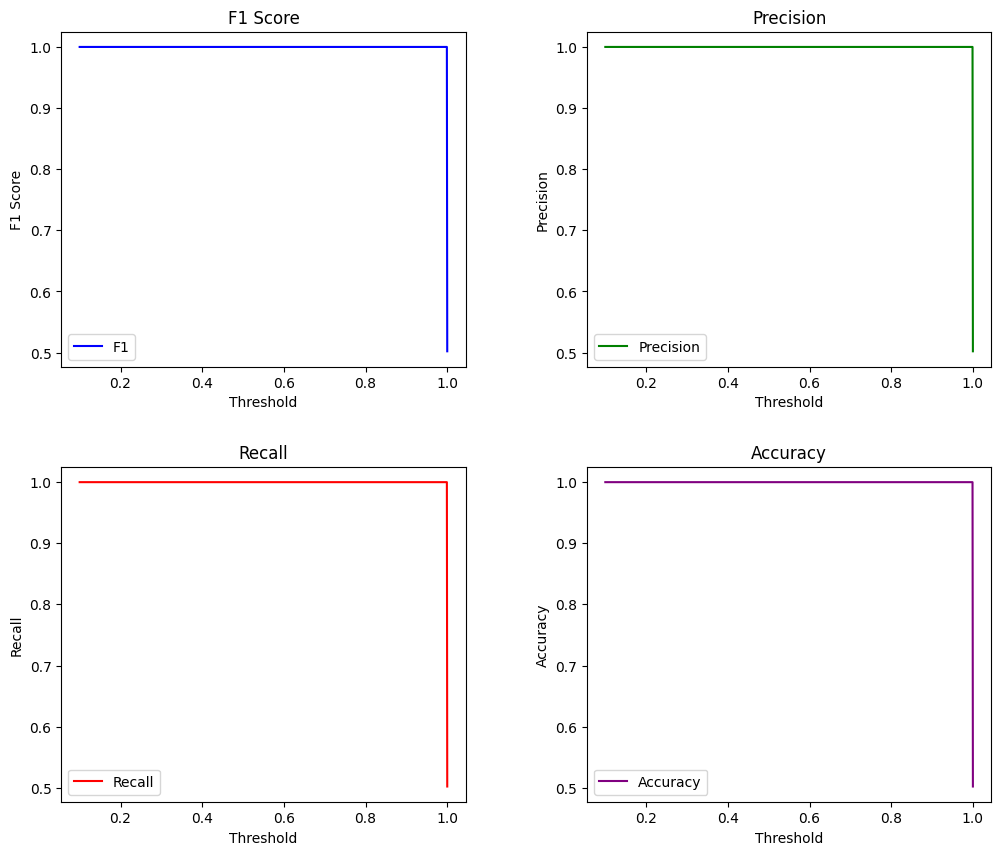

Logistic Regression Model best F1 score 1.000 at prob decision threshold >= 0.100


In [11]:
thresh_ps = np.linspace(.10, 1, 1000)
model_val_probs = LR.predict_proba(X_val)[:, 1]

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
best_f1_score, best_thresh_p = 0, 0  # Initialize best F1 score and threshold

for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    prec_scores.append(precision_score(y_val, model_val_labels, average='micro'))
    rec_scores.append(recall_score(y_val, model_val_labels, average='micro'))
    f1 = f1_score(y_val, model_val_labels, average='micro')
    f1_scores.append(f1)
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_thresh_p = p

# Create subplots with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Plot F1 score
axes[0, 0].plot(thresh_ps, f1_scores, label='F1', color='blue')
axes[0, 0].set_title('F1 Score')
axes[0, 0].set_xlabel('Threshold')
axes[0, 0].set_ylabel('F1 Score')

# Plot Precision
axes[0, 1].plot(thresh_ps, prec_scores, label='Precision', color='green')
axes[0, 1].set_title('Precision')
axes[0, 1].set_xlabel('Threshold')
axes[0, 1].set_ylabel('Precision')

# Plot Recall
axes[1, 0].plot(thresh_ps, rec_scores, label='Recall', color='red')
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('Recall')

# Plot Accuracy
axes[1, 1].plot(thresh_ps, acc_scores, label='Accuracy', color='purple')
axes[1, 1].set_title('Accuracy')
axes[1, 1].set_xlabel('Threshold')
axes[1, 1].set_ylabel('Accuracy')

# Add legends to each subplot
for ax in axes.flatten():
    ax.legend()

# Display the plots
plt.show()


print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p))


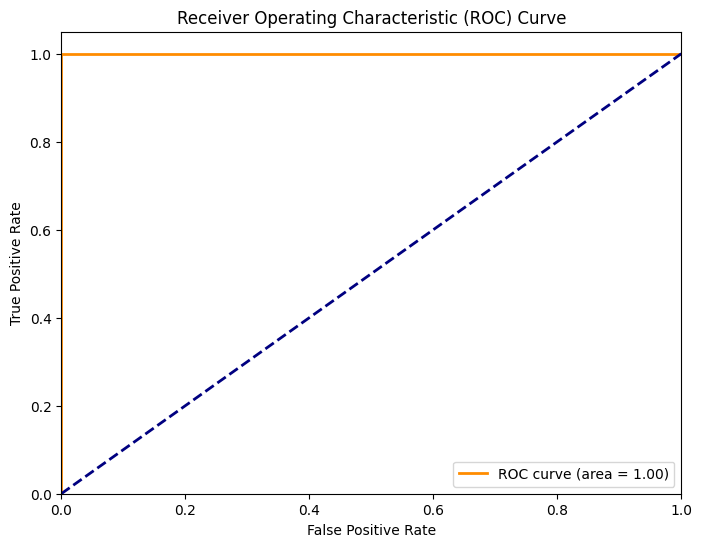

In [12]:
# Get the predicted probabilities for the positive class
model_val_probs = LR.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, model_val_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_val, model_val_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [13]:
y_predict = (LR.predict_proba(X_train)[:, 1] >= 0.65)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

Default threshold:
Precision: 1.0000,   Recall: 1.0000


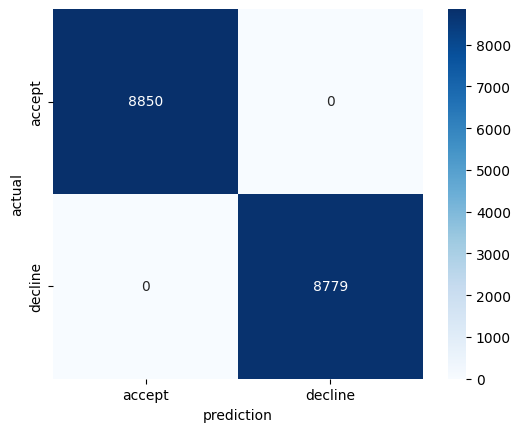

In [14]:
y_predict = (LR.predict_proba(X_val)[:, 1] >= 0.65)

confusion = confusion_matrix(y_val, y_predict)

sns.heatmap(confusion , cmap = plt.cm.Blues, annot = True , square = True , fmt = 'd',
           xticklabels = ['accept','decline'],
           yticklabels = ['accept','decline']);
plt.xlabel('prediction')
plt.ylabel('actual');

Conclusion: clearly overfitting. 

# KNeighborsClassifier

In [15]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Now, you can calculate the accuracy and F1 score
print('The accuracy for training : ', knn.score(X_train, y_train))
print('The accuracy for validation: ', knn.score(X_val, y_val))
print('F1_score for train: ', f1_score(knn.predict(X_train), y_train))
print('F1_score for validation: ', f1_score(knn.predict(X_val), y_val))

The accuracy for training :  1.0
The accuracy for validation:  1.0
F1_score for train:  1.0
F1_score for validation:  1.0


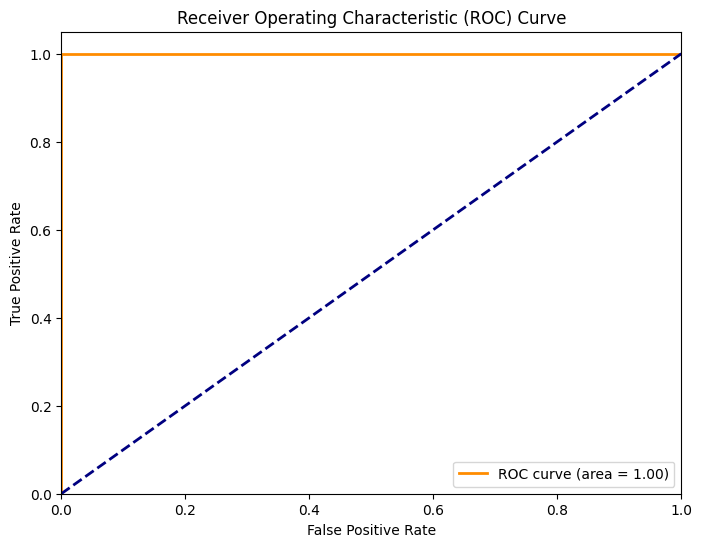

In [16]:
# Get the predicted probabilities for the positive class
model_val_probs = knn.predict_proba(X_val)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, model_val_probs)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_val, model_val_probs)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
y_predict = (knn.predict_proba(X_train)[:, 1] >= 0.65)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))

Default threshold:
Precision: 1.0000,   Recall: 1.0000


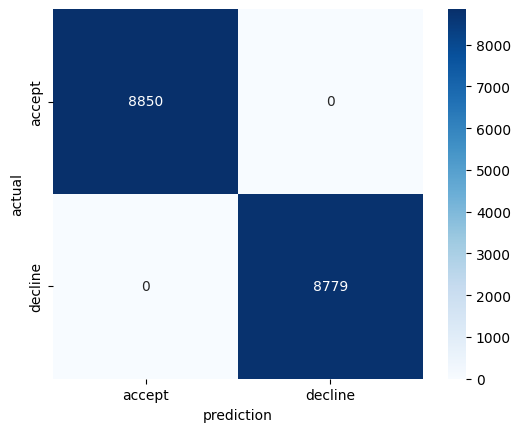

In [18]:
y_predict = (knn.predict_proba(X_val)[:, 1] >= 0.65)

confusion = confusion_matrix(y_val, y_predict)

sns.heatmap(confusion , cmap = plt.cm.Blues, annot = True , square = True , fmt = 'd',
           xticklabels = ['accept','decline'],
           yticklabels = ['accept','decline']);
plt.xlabel('prediction')
plt.ylabel('actual');

Conclusion: clearly overfitting. 

# Naive Bayes

In [19]:
Gaussian = GaussianNB()
Gaussian.fit(X_train, y_train)
print('The accuracy for training : ',Gaussian.score(X_train,y_train))
print('The accuracy for validation: ',Gaussian.score(X_val,y_val))
print('f1_score for train: ',f1_score(Gaussian.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(Gaussian.predict(X_val), y_val))

The accuracy for training :  1.0
The accuracy for validation:  1.0
f1_score for train:  1.0
f1_score for validation:  1.0


# Ada Boost Classifier

In [20]:
AB_CLF = AdaBoostClassifier(n_estimators=50, random_state=random_state)
AB_CLF.fit(X_train , y_train)
print('The accuracy for training : ',AB_CLF.score(X_train,y_train))
print('The accuracy for validation: ',AB_CLF.score(X_val,y_val))
print('f1_score for train: ',f1_score(AB_CLF.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(AB_CLF.predict(X_val), y_val))

The accuracy for training :  1.0
The accuracy for validation:  1.0
f1_score for train:  1.0
f1_score for validation:  1.0


# Stochastic Gradient Descent Algorithm

In [21]:
SG_PIP_CLF = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=100, tol=1e-3))
SG_PIP_CLF.fit(X_train , y_train)
print('The accuracy for training : ',SG_PIP_CLF.score(X_train,y_train))
print('The accuracy for validation: ',SG_PIP_CLF.score(X_val,y_val))
print('f1_score for train: ',f1_score(SG_PIP_CLF.predict(X_train), y_train))
print('f1_score for validation: ',f1_score(SG_PIP_CLF.predict(X_val), y_val))

The accuracy for training :  1.0
The accuracy for validation:  1.0
f1_score for train:  1.0
f1_score for validation:  1.0


# XGBoost (eXtreme Gradient Boosting) - this takes a very long time!

In [22]:
# Add early stopping
early_stopping_rounds = 3

xgb_model = xgb.XGBClassifier(early_stopping_rounds=early_stopping_rounds)

parameters = {
    'nthread': [4],
    'objective': ['binary:logistic'],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.7],
    'n_estimators': [8000, 9000, 10000],
    'missing': [-999],
    'seed': [1337],
    'eval_metric': ['logloss'],
}

# Use 3-fold cross-validation
clf = GridSearchCV(xgb_model, parameters, n_jobs=3,
                   cv=KFold(n_splits=3, shuffle=True, random_state=random_state),
                   scoring='neg_log_loss',  
                   verbose=4, refit=True)


# Implement early stopping
eval_set = [(X_val, y_val)]
clf.fit(X_train, y_train, eval_set=eval_set)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[0]	validation_0-logloss:0.43751
[1]	validation_0-logloss:0.29632
[2]	validation_0-logloss:0.20734
[3]	validation_0-logloss:0.14782
[4]	validation_0-logloss:0.10662
[5]	validation_0-logloss:0.07751
[6]	validation_0-logloss:0.05665
[7]	validation_0-logloss:0.04157
[8]	validation_0-logloss:0.03058
[9]	validation_0-logloss:0.02254
[10]	validation_0-logloss:0.01664
[11]	validation_0-logloss:0.01230
[12]	validation_0-logloss:0.00910
[13]	validation_0-logloss:0.00674
[14]	validation_0-logloss:0.00499
[15]	validation_0-logloss:0.00370
[16]	validation_0-logloss:0.00275
[17]	validation_0-logloss:0.00204


C:\Users\asche\anaconda3\envs\Test\lib\site-packages\xgboost\data.py:427: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[18]	validation_0-logloss:0.00152
[19]	validation_0-logloss:0.00113
[20]	validation_0-logloss:0.00085
[21]	validation_0-logloss:0.00063
[22]	validation_0-logloss:0.00048
[23]	validation_0-logloss:0.00036
[24]	validation_0-logloss:0.00027
[25]	validation_0-logloss:0.00021
[26]	validation_0-logloss:0.00016
[27]	validation_0-logloss:0.00012
[28]	validation_0-logloss:0.00010
[29]	validation_0-logloss:0.00008
[30]	validation_0-logloss:0.00006
[31]	validation_0-logloss:0.00005
[32]	validation_0-logloss:0.00004
[33]	validation_0-logloss:0.00004
[34]	validation_0-logloss:0.00003
[35]	validation_0-logloss:0.00003
[36]	validation_0-logloss:0.00003


GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=3,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     intera...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=3,
             param_grid={'colsample_bytree': [0.7], 'eval_metric': ['logloss'],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 5, 10],
                         'missing': [-999], 'n_estimators': [8000, 9000, 10000],
                         'nthread': [4], 'objective': ['binary:logistic'],
                         'seed': [1337], 'subsample': [0.5, 0.7, 0.9]},
             scoring='neg_log_loss', verbose=4)

In [23]:
import pickle

with open('xgboost_model.pkl', 'wb') as file:
    pickle.dump(clf, file)

In [24]:
clf.best_params_

{'colsample_bytree': 0.7,
 'eval_metric': 'logloss',
 'learning_rate': 0.3,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': -999,
 'n_estimators': 8000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 1337,
 'subsample': 0.9}

In [25]:
# Define your hyperparameters
params = {
    'colsample_bytree': 0.7,
    'eval_metric': 'logloss',  # Specify eval_metric during initialization
    'learning_rate': 0.3,
    'max_depth': 3,
    'min_child_weight': 1,
    'missing': -999,
    'n_estimators': 8000,
    'nthread': 4,
    'objective': 'binary:logistic',
    'seed': 1337,
    'subsample': 0.9
}

In [27]:
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score

# Define and initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(**params, early_stopping_rounds=3)

# Train (fit) the model
eval_set = [(X_val, y_val)]
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# Make predictions
y_predict = (xgb_model.predict_proba(X_train)[:, 1] >= 0.59)

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_train, y_predict), 
                                                     recall_score(y_train, y_predict)))


[0]	validation_0-logloss:0.43751
[1]	validation_0-logloss:0.29632
[2]	validation_0-logloss:0.20734
[3]	validation_0-logloss:0.14782
[4]	validation_0-logloss:0.10662
[5]	validation_0-logloss:0.07751
[6]	validation_0-logloss:0.05665
[7]	validation_0-logloss:0.04157
[8]	validation_0-logloss:0.03058
[9]	validation_0-logloss:0.02254
[10]	validation_0-logloss:0.01664
[11]	validation_0-logloss:0.01230
[12]	validation_0-logloss:0.00910
[13]	validation_0-logloss:0.00674
[14]	validation_0-logloss:0.00499
[15]	validation_0-logloss:0.00370
[16]	validation_0-logloss:0.00275
[17]	validation_0-logloss:0.00204
[18]	validation_0-logloss:0.00152
[19]	validation_0-logloss:0.00113
[20]	validation_0-logloss:0.00085
[21]	validation_0-logloss:0.00063
[22]	validation_0-logloss:0.00048
[23]	validation_0-logloss:0.00036
[24]	validation_0-logloss:0.00027
[25]	validation_0-logloss:0.00021
[26]	validation_0-logloss:0.00016
[27]	validation_0-logloss:0.00012
[28]	validation_0-logloss:0.00010
[29]	validation_0-loglos

C:\Users\asche\anaconda3\envs\Test\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


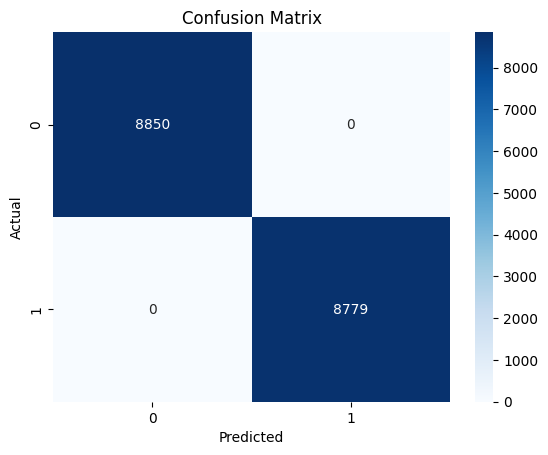

In [28]:
# Get predictions on the validation dataset
y_pred = xgb_model.predict(X_val, ntree_limit=xgb_model.best_ntree_limit)

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels and titles
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()


# Pickle models

In [29]:
lr_model = linear_model.LogisticRegression(solver="lbfgs", random_state=random_state)
dt_model = tree.DecisionTreeClassifier(max_depth=8)
ADA_model = AdaBoostClassifier(n_estimators=50, random_state=random_state)
SGD_model = make_pipeline(StandardScaler(),
                     SGDClassifier(max_iter=100, tol=1e-3))

models = ["lr_model","dt_model","ADA_model","SGD_model"]

In [30]:
for model_name in models:
    
    curr_model = eval(model_name)
    
    curr_model.fit(X_train, y_train)
    
    with open(f"{model_name}.pickle", "wb") as pfile:
        pickle.dump(curr_model, pfile)

In [31]:
model_names = ["lr_model","dt_model","ADA_model","SGD_model"]

for model_name in model_names:
    with open(f"{model_name}.pickle", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [32]:
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_train, y_train)}')
    print(f'{model_name} score: {curr_model.score(X_val, y_val)}')

lr_model score: 1.0
lr_model score: 1.0
dt_model score: 1.0
dt_model score: 1.0
ADA_model score: 1.0
ADA_model score: 1.0
SGD_model score: 1.0
SGD_model score: 1.0


# voting classifer (HARD)

In [33]:
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', #<-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_train, y_train)

VotingClassifier(estimators=[('lr_model', LogisticRegression(random_state=42)),
                             ('dt_model', DecisionTreeClassifier(max_depth=8)),
                             ('ADA_model', AdaBoostClassifier(random_state=42)),
                             ('SGD_model',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('sgdclassifier',
                                               SGDClassifier(max_iter=100))]))],
                 n_jobs=-1)

In [34]:
y_pred = voting_classifer.predict(X_train)
accuracy_score(y_train, y_pred)

1.0

In [35]:
y_pred = voting_classifer.predict(X_val)
accuracy_score(y_val, y_pred)

1.0

# Compare all the models.

In [36]:
# Example model and prediction data
models = ['LR', 'knn', 'Ada Boost', 'Gaussian', 'Stochastic Gradient Descent', 'xgb_model', 'Decision Tree', 'SGD_model', 'voting_classifier']
y_pred1 = LR.predict(X_val)
y_pred2 = knn.predict(X_val)
y_pred3 = AB_CLF.predict(X_val)
y_pred4 = Gaussian.predict(X_val)
y_pred5 = SG_PIP_CLF.predict(X_val)
y_pred6 = xgb_model.predict(X_val)
y_pred7 = dt_model.predict(X_val)
y_pred8 = SGD_model.predict(X_val)
y_pred9 = voting_classifer.predict(X_val)  # Fixed variable name

y_true = y_val  # True labels

# Calculate evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    'Accuracy': [accuracy_score(y_true, y_pred1), accuracy_score(y_true, y_pred2), accuracy_score(y_true, y_pred3),
                 accuracy_score(y_true, y_pred4), accuracy_score(y_true, y_pred5), accuracy_score(y_true, y_pred6),
                 accuracy_score(y_true, y_pred7), accuracy_score(y_true, y_pred8), accuracy_score(y_true, y_pred9)],
    
    'Precision': [precision_score(y_true, y_pred1), precision_score(y_true, y_pred2), precision_score(y_true, y_pred3),
                  precision_score(y_true, y_pred4), precision_score(y_true, y_pred5), precision_score(y_true, y_pred6),
                  precision_score(y_true, y_pred7), precision_score(y_true, y_pred8), precision_score(y_true, y_pred9)],
    
    'Recall': [recall_score(y_true, y_pred1), recall_score(y_true, y_pred2), recall_score(y_true, y_pred3),
               recall_score(y_true, y_pred4), recall_score(y_true, y_pred5), recall_score(y_true, y_pred6),
               recall_score(y_true, y_pred7), recall_score(y_true, y_pred8), recall_score(y_true, y_pred9)],
    
    'F1 Score': [f1_score(y_true, y_pred1), f1_score(y_true, y_pred2), f1_score(y_true, y_pred3),
                 f1_score(y_true, y_pred4), f1_score(y_true, y_pred5), f1_score(y_true, y_pred6),
                 f1_score(y_true, y_pred7), f1_score(y_true, y_pred8), f1_score(y_true, y_pred9)]
}

# Create a DataFrame
import pandas as pd
df = pd.DataFrame(metrics, index=models)

# Display the DataFrame
print(df)


                             Accuracy  Precision  Recall  F1 Score
LR                                1.0        1.0     1.0       1.0
knn                               1.0        1.0     1.0       1.0
Ada Boost                         1.0        1.0     1.0       1.0
Gaussian                          1.0        1.0     1.0       1.0
Stochastic Gradient Descent       1.0        1.0     1.0       1.0
xgb_model                         1.0        1.0     1.0       1.0
Decision Tree                     1.0        1.0     1.0       1.0
SGD_model                         1.0        1.0     1.0       1.0
voting_classifier                 1.0        1.0     1.0       1.0
